### Load image and label

In [7]:
import os

path = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ".avi" in file:
            files.append(os.path.join(r, file))
        
for f in files:
    print(f)

.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\nonsleepyCombination.avi
.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\sleepyCombination.avi
.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\slowBlinkWithNodding.avi
.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\yawning.avi


### Crop image and Label
[HAAR Classifier](http://blog.topspeedsnail.com/archives/10511)
- haarcascade_frontalface_default(想法: 直接用這個切出臉部的框框)
- haarcascade_eye
- problem: 多個人臉的問題防範
- 用landmark下去圈，否則會不夠精準

In [8]:
import numpy as np
import cv2

#==================Detector
face_haar = cv2.CascadeClassifier(".\Tool\Detecter\haarcascade_frontalface_default.xml")
eye_haar = cv2.CascadeClassifier(".\Tool\Detecter\haarcascade_eye.xml")
mouth_haar = cv2.CascadeClassifier(".\Tool\Detecter\haarcascade_mcs_mouth.xml")
nose_haar = cv2.CascadeClassifier(".\Tool\Detecter\haarcascade_mcs_nose.xml")
#==================

filename = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\005\sunglasses\yawning.avi'
cap = cv2.VideoCapture(filename)

while(cap.isOpened()):
    ret, frame = cap.read()
    #print(type(frame))
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #===========Detect global part and local part by haar
    faces = face_haar.detectMultiScale(gray_img, 1.3, 5)
    #faces = face_haar.detectMultiScale(gray_img,scaleFactor=1.15,minNeighbors=5,minSize=(5,5),flags = cv2.CASCADE_SCALE_IMAGE)
    for face_x,face_y,face_w,face_h in faces:
        cv2.rectangle(frame, (face_x, face_y), (face_x+face_w, face_y+face_h), (0,255,0), 2)
            # 眼长在脸上
        roi_gray_img = gray_img[face_y:face_y+face_h, face_x:face_x+face_w]
        roi_img = frame[face_y:face_y+face_h, face_x:face_x+face_w]

        eyes = eye_haar.detectMultiScale(roi_gray_img, 1.3, 5)
        for eye_x,eye_y,eye_w,eye_h in eyes:
            cv2.rectangle(roi_img, (eye_x,eye_y), (eye_x+eye_w, eye_y+eye_h), (255,0,0), 2)

        noses = nose_haar.detectMultiScale(roi_gray_img, 1.7, 5)
        for nose_x,nose_y,nose_w,nose_h in noses:
            cv2.rectangle(roi_img, (nose_x,nose_y), (nose_x+nose_w, nose_y+nose_h), (255,0,255), 2)

        mouthes = mouth_haar.detectMultiScale(roi_gray_img, 1.5, 7)
        for mouth_x,mouth_y,mouth_w,mouth_h in mouthes:
            cv2.rectangle(roi_img, (mouth_x,mouth_y), (mouth_x+mouth_w, mouth_y+mouth_h), (255,255,0), 2)
                
    cv2.imshow('frame',frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### landmark

- [reference](https://github.com/italojs/facial-landmarks-recognition-)
- [find max value of the same index](https://stackoverflow.com/questions/39748916/find-maximum-value-and-index-in-a-python-list)<br>
解釋了為什麼要再用CNN，因為landmark無法偵測得很精準。
1~27: 臉部輪廓
28~36:鼻子
37~42:左眼
43~48:右眼
49~68:嘴巴

In [9]:
import os

path = '.\\Dataset\\Training_Evaluation_Dataset\\Training Dataset\\001\\glasses'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ".avi" in file:
            files.append(os.path.join(r, file))
        
for f in files:
    print(f)

.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\nonsleepyCombination.avi
.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\sleepyCombination.avi
.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\slowBlinkWithNodding.avi
.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\yawning.avi


In [10]:
# import the necessary packages
from imutils import face_utils
import dlib
import cv2
import os 
import numpy as np
from operator import itemgetter

DefaultPath = '.\\Dataset\\'

def CreateFolder(name):
    try:
        # creating a folder named data 
        if not os.path.exists(name):
            os.makedirs(name)
        # if not created then raise error 
    except OSError: 
        print ('Error: Creating directory of data')        
        
#==============================================================

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

filename = '.\\Dataset\\Training_Evaluation_Dataset\\Training Dataset\\001\\glasses\\yawning.avi'
print(filename)
cap = cv2.VideoCapture(filename)

#================================================================ create new folder
CreateFolder(DefaultPath+"face")
CreateFolder(DefaultPath+"lefteye")
CreateFolder(DefaultPath+"righteye")
CreateFolder(DefaultPath+"nose")
CreateFolder(DefaultPath+"mouth")
#================================================================
Face_ImageDataList = []

currentframe = 0

while(cap.isOpened()):
    currentframe += 1
    # load the input image and convert it to grayscale
    ret, image = cap.read()
    if (not ret):
      break
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
        
    # detect faces in the grayscale image
    rects = detector(gray, 0)
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        #count = 0
        face_x = face_y = 0
        
        #face_y = face_y-1
        #face_x = face_x+1
        #print(str(face_x)+" "+str(face_y))
        
        '''
        for (x, y) in shape:
            #count = count+1
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            #if():
            
            #if(count>=49 and count<=69):
                #cv2.putText(image,str(count), (x+2 , y+2 ), cv2.FONT_HERSHEY_COMPLEX,0.5, (0, 255, 255))
        '''
        
        #print(shape[0:3][0])
        #print(shape[1:10])
        #index, value = max(shape[1:10], key=lambda item: item[1])
       
        #max_value = max(shape[1:10], key=itemgetter(1))[0]
        #print(value)
        
        #print(max(shape[0:28], key=itemgetter(0))[0])#find max value of x 
        #print(max(shape[0:28], key=itemgetter(1))[1])#find max value of y 
        
        #==================================================Detect local part and global part
        face_max_x = max(shape[0:27], key=itemgetter(0))[0]+15
        face_min_x = min(shape[0:27], key=itemgetter(0))[0]-15
        face_max_y = max(shape[0:27], key=itemgetter(1))[1]+15
        face_min_y = min(shape[0:27], key=itemgetter(1))[1]-15
        face_image = image[face_min_y:face_max_y,face_min_x:face_max_x]
        face_image = cv2.resize(face_image,(64,64),interpolation=cv2.INTER_AREA)
        cv2.imwrite(DefaultPath + "face/frame" + str(currentframe) + '.jpg',face_image) 
        #Face_ImageDataList.append(face_image)
        #cv2.rectangle(image,(face_min_x,face_min_y),(face_max_x,face_max_y),(0, 255, 255),2)
        
        
        
        nose_max_x = max(shape[27:36], key=itemgetter(0))[0]+15
        nose_min_x = min(shape[27:36], key=itemgetter(0))[0]-15
        nose_max_y = max(shape[27:36], key=itemgetter(1))[1]+10
        nose_min_y = min(shape[27:36], key=itemgetter(1))[1]
        nose_image = image[nose_min_y:nose_max_y,nose_min_x:nose_max_x]
        cv2.imwrite(DefaultPath + "nose/frame" + str(currentframe) + '.jpg',nose_image)
        #cv2.rectangle(image,(nose_min_x,nose_min_y),(nose_max_x,nose_max_y),(255, 255, 0),2)
        
        lefteye_max_x = max(shape[36:42], key=itemgetter(0))[0]+15
        lefteye_min_x = min(shape[36:42], key=itemgetter(0))[0]-15
        lefteye_max_y = max(shape[36:42], key=itemgetter(1))[1]+15
        lefteye_min_y = min(shape[36:42], key=itemgetter(1))[1]-15
        lefteye_image = image[lefteye_min_y:lefteye_max_y,lefteye_min_x:lefteye_max_x]
        cv2.imwrite(DefaultPath + "lefteye/frame" + str(currentframe) + '.jpg',lefteye_image)
        #cv2.rectangle(image,(lefteye_min_x,lefteye_min_y),(lefteye_max_x,lefteye_max_y),(255, 0, 0),2)
        
        righteye_max_x = max(shape[42:48], key=itemgetter(0))[0]+15
        righteye_min_x = min(shape[42:48], key=itemgetter(0))[0]-15
        righteye_max_y = max(shape[42:48], key=itemgetter(1))[1]+15
        righteye_min_y = min(shape[42:48], key=itemgetter(1))[1]-15
        righteye_image = image[righteye_min_y:righteye_max_y,righteye_min_x:righteye_max_x]
        cv2.imwrite(DefaultPath + "righteye/frame" + str(currentframe) + '.jpg',righteye_image)
        #cv2.rectangle(image,(righteye_min_x,righteye_min_y),(righteye_max_x,righteye_max_y),(255, 255, 255),2)
        
        mouth_max_x = max(shape[48:], key=itemgetter(0))[0]+15
        mouth_min_x = min(shape[48:], key=itemgetter(0))[0]-15
        mouth_max_y = max(shape[48:], key=itemgetter(1))[1]+15
        mouth_min_y = min(shape[48:], key=itemgetter(1))[1]-15
        mouth_image = image[mouth_min_y:mouth_max_y,mouth_min_x:mouth_max_x]
        cv2.imwrite(DefaultPath + "mouth/frame" + str(currentframe) + '.jpg',mouth_image)
        #cv2.rectangle(image,(mouth_min_x,mouth_min_y),(mouth_max_x,mouth_max_y),(255, 0, 255),2)
        
        if(currentframe%100==0):
            print ('Creating frame' + str(currentframe)) 
        #==================================================
        
        '''
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (255, 0, 0), -1)
        '''    
    # show the output image with the face detections + facial landmarks
    '''
    cv2.imshow("Output", image)
    cv2.imshow("face_image", face_image)
    cv2.imshow("nose_image", nose_image)
    cv2.imshow("lefteye_image", lefteye_image)
    cv2.imshow("righteye_image", righteye_image)
    cv2.imshow("mouth_image", mouth_image)
    
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break
    '''
cv2.destroyAllWindows()
cap.release()

.\Dataset\Training_Evaluation_Dataset\Training Dataset\001\glasses\yawning.avi
Creating frame100
Creating frame200
Creating frame300
Creating frame400
Creating frame500
Creating frame600
Creating frame700
Creating frame800
Creating frame900
Creating frame1000
Creating frame1100
Creating frame1200
Creating frame1300
Creating frame1400
Creating frame1500
Creating frame1600
Creating frame1700
Creating frame1800


### Load Label

In [56]:
import numpy as np
#注意開頭是數字的資料夾或檔案
labelfile = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses\\001_yawning_drowsiness.txt'
LabelList = []

inputfile = open(labelfile, 'r').read()


LabelList = list(map(int, inputfile))
Labelarray = np.array(LabelList)
Labelarray.shape

(1850,)

### test

In [2]:
# Importing all necessary libraries 
import cv2 

  
# Read the video from specified path 
cam = cv2.VideoCapture('.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses\yawning.avi') 
  
try: 
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 
  
# frame 
currentframe = 0
  
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
  
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr

Creating..../data/frame272.jpg
Creating..../data/frame273.jpg
Creating..../data/frame274.jpg
Creating..../data/frame275.jpg
Creating..../data/frame276.jpg
Creating..../data/frame277.jpg
Creating..../data/frame278.jpg
Creating..../data/frame279.jpg
Creating..../data/frame280.jpg
Creating..../data/frame281.jpg
Creating..../data/frame282.jpg
Creating..../data/frame283.jpg
Creating..../data/frame284.jpg
Creating..../data/frame285.jpg
Creating..../data/frame286.jpg
Creating..../data/frame287.jpg
Creating..../data/frame288.jpg
Creating..../data/frame289.jpg
Creating..../data/frame290.jpg
Creating..../data/frame291.jpg
Creating..../data/frame292.jpg
Creating..../data/frame293.jpg
Creating..../data/frame294.jpg
Creating..../data/frame295.jpg
Creating..../data/frame296.jpg
Creating..../data/frame297.jpg
Creating..../data/frame298.jpg
Creating..../data/frame299.jpg
Creating..../data/frame300.jpg
Creating..../data/frame301.jpg
Creating..../data/frame302.jpg
Creating..../data/frame303.jpg
Creating

Creating..../data/frame548.jpg
Creating..../data/frame549.jpg
Creating..../data/frame550.jpg
Creating..../data/frame551.jpg
Creating..../data/frame552.jpg
Creating..../data/frame553.jpg
Creating..../data/frame554.jpg
Creating..../data/frame555.jpg
Creating..../data/frame556.jpg
Creating..../data/frame557.jpg
Creating..../data/frame558.jpg
Creating..../data/frame559.jpg
Creating..../data/frame560.jpg
Creating..../data/frame561.jpg
Creating..../data/frame562.jpg
Creating..../data/frame563.jpg
Creating..../data/frame564.jpg
Creating..../data/frame565.jpg
Creating..../data/frame566.jpg
Creating..../data/frame567.jpg
Creating..../data/frame568.jpg
Creating..../data/frame569.jpg
Creating..../data/frame570.jpg
Creating..../data/frame571.jpg
Creating..../data/frame572.jpg
Creating..../data/frame573.jpg
Creating..../data/frame574.jpg
Creating..../data/frame575.jpg
Creating..../data/frame576.jpg
Creating..../data/frame577.jpg
Creating..../data/frame578.jpg
Creating..../data/frame579.jpg
Creating

Creating..../data/frame817.jpg
Creating..../data/frame818.jpg
Creating..../data/frame819.jpg
Creating..../data/frame820.jpg
Creating..../data/frame821.jpg
Creating..../data/frame822.jpg
Creating..../data/frame823.jpg
Creating..../data/frame824.jpg
Creating..../data/frame825.jpg
Creating..../data/frame826.jpg
Creating..../data/frame827.jpg
Creating..../data/frame828.jpg
Creating..../data/frame829.jpg
Creating..../data/frame830.jpg
Creating..../data/frame831.jpg
Creating..../data/frame832.jpg
Creating..../data/frame833.jpg
Creating..../data/frame834.jpg
Creating..../data/frame835.jpg
Creating..../data/frame836.jpg
Creating..../data/frame837.jpg
Creating..../data/frame838.jpg
Creating..../data/frame839.jpg
Creating..../data/frame840.jpg
Creating..../data/frame841.jpg
Creating..../data/frame842.jpg
Creating..../data/frame843.jpg
Creating..../data/frame844.jpg
Creating..../data/frame845.jpg
Creating..../data/frame846.jpg
Creating..../data/frame847.jpg
Creating..../data/frame848.jpg
Creating

Creating..../data/frame1079.jpg
Creating..../data/frame1080.jpg
Creating..../data/frame1081.jpg
Creating..../data/frame1082.jpg
Creating..../data/frame1083.jpg
Creating..../data/frame1084.jpg
Creating..../data/frame1085.jpg
Creating..../data/frame1086.jpg
Creating..../data/frame1087.jpg
Creating..../data/frame1088.jpg
Creating..../data/frame1089.jpg
Creating..../data/frame1090.jpg
Creating..../data/frame1091.jpg
Creating..../data/frame1092.jpg
Creating..../data/frame1093.jpg
Creating..../data/frame1094.jpg
Creating..../data/frame1095.jpg
Creating..../data/frame1096.jpg
Creating..../data/frame1097.jpg
Creating..../data/frame1098.jpg
Creating..../data/frame1099.jpg
Creating..../data/frame1100.jpg
Creating..../data/frame1101.jpg
Creating..../data/frame1102.jpg
Creating..../data/frame1103.jpg
Creating..../data/frame1104.jpg
Creating..../data/frame1105.jpg
Creating..../data/frame1106.jpg
Creating..../data/frame1107.jpg
Creating..../data/frame1108.jpg
Creating..../data/frame1109.jpg
Creating

Creating..../data/frame1348.jpg
Creating..../data/frame1349.jpg
Creating..../data/frame1350.jpg
Creating..../data/frame1351.jpg
Creating..../data/frame1352.jpg
Creating..../data/frame1353.jpg
Creating..../data/frame1354.jpg
Creating..../data/frame1355.jpg
Creating..../data/frame1356.jpg
Creating..../data/frame1357.jpg
Creating..../data/frame1358.jpg
Creating..../data/frame1359.jpg
Creating..../data/frame1360.jpg
Creating..../data/frame1361.jpg
Creating..../data/frame1362.jpg
Creating..../data/frame1363.jpg
Creating..../data/frame1364.jpg
Creating..../data/frame1365.jpg
Creating..../data/frame1366.jpg
Creating..../data/frame1367.jpg
Creating..../data/frame1368.jpg
Creating..../data/frame1369.jpg
Creating..../data/frame1370.jpg
Creating..../data/frame1371.jpg
Creating..../data/frame1372.jpg
Creating..../data/frame1373.jpg
Creating..../data/frame1374.jpg
Creating..../data/frame1375.jpg
Creating..../data/frame1376.jpg
Creating..../data/frame1377.jpg
Creating..../data/frame1378.jpg
Creating

Creating..../data/frame1612.jpg
Creating..../data/frame1613.jpg
Creating..../data/frame1614.jpg
Creating..../data/frame1615.jpg
Creating..../data/frame1616.jpg
Creating..../data/frame1617.jpg
Creating..../data/frame1618.jpg
Creating..../data/frame1619.jpg
Creating..../data/frame1620.jpg
Creating..../data/frame1621.jpg
Creating..../data/frame1622.jpg
Creating..../data/frame1623.jpg
Creating..../data/frame1624.jpg
Creating..../data/frame1625.jpg
Creating..../data/frame1626.jpg
Creating..../data/frame1627.jpg
Creating..../data/frame1628.jpg
Creating..../data/frame1629.jpg
Creating..../data/frame1630.jpg
Creating..../data/frame1631.jpg
Creating..../data/frame1632.jpg
Creating..../data/frame1633.jpg
Creating..../data/frame1634.jpg
Creating..../data/frame1635.jpg
Creating..../data/frame1636.jpg
Creating..../data/frame1637.jpg
Creating..../data/frame1638.jpg
Creating..../data/frame1639.jpg
Creating..../data/frame1640.jpg
Creating..../data/frame1641.jpg
Creating..../data/frame1642.jpg
Creating

1. LSTM simple => know how to store data <br>
2. Determine how to fix size
3. Deal with the issue that cannot detect landmark => 抓上一個frame 附近的frame
4. CNN model <br>
5. 3 channels <br>

[LSTM](https://blog.csdn.net/u011311291/article/details/79292032)

### Temp

In [1]:
import numpy as np
from keras.utils import to_categorical
#注意開頭是數字的資料夾或檔案
labelfile = '.\Dataset\Training_Evaluation_Dataset\Training Dataset\\001\glasses\\001_yawning_drowsiness.txt'
LabelList = []

inputfile = open(labelfile, 'r').read()


LabelList = list(map(int, inputfile))
Labelarray = np.array(LabelList)

Labelarray = to_categorical(Labelarray)
print(Labelarray.shape)

Using TensorFlow backend.


(1850, 2)


In [2]:
import os

path = '.\\Dataset\\face\\'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ".jpg" in file:
            files.append(os.path.join(r, file))
        
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
'''
for f in files:
    print(f)
'''


'\nfor f in files:\n    print(f)\n'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
Face_ImageDataList = []
for f in files:
    ImgGray = cv2.imread(f,0)
    ImgRGB = cv2.merge((ImgGray,ImgGray,ImgGray))# this line make gray image to RGB
    Face_ImageDataList.append(ImgRGB)   
    #print(f)

(1850, 64, 64, 3)

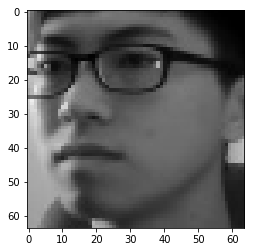

In [4]:
Face_ImageDataList
Facearray = np.array(Face_ImageDataList)

plt.imshow(Facearray[0], cmap='gray')
#Facearray.reshape(1850,4096)
#Facearray
Facearray.shape

### CNN LSTM
https://stackoverflow.com/questions/36992340/how-do-you-pass-video-features-from-a-cnn-to-an-lstm

problem: CNN的input一筆資料是一張圖片，LSTM則是一個影片。所以才要用multistage的方式。

先還是用圖片餵進去試試看
[VGG16](https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg)<br>
[Ref](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)<br>
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]<br>
一個window裡面有許多timestamp，表示LSTM記憶要看幾個frame(幾個timestamp)

In [5]:
from keras.applications.vgg16 import VGG16
from keras import applications
from keras.layers import Input

img_width, img_height = 64, 64

vgg_model = applications.VGG16(weights='imagenet', include_top=False,input_shape = (64, 64, 3))
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [6]:
#在VGG16的block2_pool output再加layer，VGG16的3 4 5就不要了
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])
layer_dict

{'input_1': <keras.engine.input_layer.InputLayer at 0x29da4fb3ef0>,
 'block1_conv1': <keras.layers.convolutional.Conv2D at 0x29da4fb3860>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x29da4fb3048>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x29da4ff8438>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x29da4ff82b0>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x29db4a6ad30>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x29dae9c9630>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x29db4a98048>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x29db4ab73c8>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x29db4ad2080>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x29db4b06080>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x29db4b060b8>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x29db4b20470>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x29db4b40080>,
 'block4_poo

In [7]:
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import concatenate
#Functional API



Conv2_out = layer_dict['block2_pool'].output

Conv3_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv2_out)
Conv3_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv3_out)
Conv3_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv3_out)
Conv3_Poolout = MaxPooling2D(pool_size=(2, 2))(Conv3_out)

Conv4_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv3_Poolout)
Conv4_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv4_out)
Conv4_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv4_out)
Conv4_Poolout = MaxPooling2D(pool_size=(2, 2))(Conv4_out)

Conv5_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv4_Poolout)
Conv5_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv5_out)
Conv5_out = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='same',kernel_initializer='random_uniform')(Conv5_out)
Conv5_Poolout = MaxPooling2D(pool_size=(2, 2))(Conv5_out)


FC6_1 = MaxPooling2D(pool_size=(16, 16))(Conv3_out)
FC6_2 = MaxPooling2D(pool_size=(8, 8))(Conv4_out)
FC6_3 = MaxPooling2D(pool_size=(4, 4))(Conv5_out)

FC6_in=concatenate([FC6_1,FC6_2,FC6_3])

out = Flatten()(FC6_in)
out = Dense(256, activation='relu',kernel_initializer='random_uniform')(out)
out = Dense(256, activation='relu',kernel_initializer='random_uniform')(out)
out = Dense(2, activation='softmax',kernel_initializer='random_uniform')(out)


In [8]:
from keras.models import Model
from keras import optimizers
custom_model = Model(input=vgg_model.input, output=out)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:7]:
    layer.trainable = False
    print(layer)


sgd = optimizers.SGD(lr=0.000005, decay=0.0005, momentum=0.9, nesterov=True)
# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer=sgd, 
                     metrics=['accuracy'])

custom_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
model_result = custom_model.fit(Facearray, Labelarray,
                        batch_size = 1,
                        epochs = 40,
                        verbose = 1)

Epoch 1/40
1850/1850 [==============================] - 20s 11ms/step - loss: 0.6171 - acc: 0.6670
Epoch 2/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.4419 - acc: 0.7984
Epoch 3/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.3640 - acc: 0.8562
Epoch 4/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.3244 - acc: 0.8730
Epoch 5/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.2894 - acc: 0.9005
Epoch 6/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.2696 - acc: 0.9092
Epoch 7/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.2554 - acc: 0.9200
Epoch 8/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.2420 - acc: 0.9249
Epoch 9/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.2264 - acc: 0.9351
Epoch 10/40
1850/1850 [==============================] - 17s 9ms/step - loss: 0.2146 - acc: 0.9395
Epoch 11/40
1850/1

In [79]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.callbacks import TensorBoard

# define dataset
X = Facearray
y = Labelarray

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# 4 samples (X.shape[0])
timesteps = 50
print(X.shape)
X = X.reshape(int(X.shape[0]/timesteps), 1, timesteps, 4096)

print(X.shape)
X

(1850, 64, 64)
(37, 1, 50, 4096)


array([[[[161, 116,  87, ...,  30,  27,  30],
         [188, 166, 119, ...,  39,  28,  30],
         [186, 151, 110, ...,  54,  30,  30],
         ...,
         [118,  98,  76, ...,  30,  28,  27],
         [114,  88,  74, ...,  30,  27,  28],
         [142, 112,  85, ...,  29,  28,  27]]],


       [[[134, 111,  82, ...,  29,  28,  27],
         [119,  91,  74, ...,  28,  26,  28],
         [139, 106,  82, ...,  30,  25,  28],
         ...,
         [196, 195, 191, ...,  25,  26,  25],
         [197, 193, 173, ...,  24,  27,  24],
         [196, 196, 187, ...,  26,  26,  25]]],


       [[[143,  55,  34, ...,  26,  26,  25],
         [190, 170,  78, ...,  25,  25,  26],
         [193, 185, 128, ...,  26,  29,  25],
         ...,
         [197, 183, 143, ...,  25,  26,  24],
         [196, 194, 185, ...,  26,  25,  25],
         [196, 199, 192, ...,  25,  26,  25]]],


       ...,


       [[[191, 169, 123, ...,  27,  24,  27],
         [173, 141,  94, ...,  36,  29,  27],
         [16

In [85]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 50, 4096)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_43 (TimeDis (None, None, 50, 64)      262208    
_________________________________________________________________
time_distributed_44 (TimeDis (None, None, 25, 64)      0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, None, 1600)        0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               680400    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 942,709
Trainable params: 942,709
Non-trainable params: 0
_________________________________________________________________


In [86]:
# fit model
model.fit(X, y, epochs=500)
#model.fit(X, y, epochs=50,callbacks=[TensorBoard(log_dir='./log_dir')])

ValueError: Error when checking target: expected dense_15 to have shape (1,) but got array with shape (50,)

In [ ]:
# demonstrate prediction
x_input = array([50, 60, 70, 80])
x_input = x_input.reshape((1, 2, 2, 1))
yhat = model.predict(x_input, verbose=0)